In [ ]:
from local.torch_basics import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.all import *

In [ ]:
path = untar_data(URLs.CAMVID)

In [ ]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [ ]:
def ListSplitter(valid_items):
    def _inner(items):
        val_mask = tensor([o.name in valid_items for o in items])
        return [~val_mask,val_mask]
    return _inner

In [ ]:
camvid = DataBlock(types=(PILImage, PILMask),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}')

In [ ]:
dbunch = camvid.databunch(path/"images", bs=16, item_tfms=Resize((360,480)), 
                          batch_tfms=[*aug_transforms(), Normalize(*imagenet_stats)])

In [ ]:
len(dbunch.train_ds.tls[0].items),len(dbunch.valid_ds.tls[0].items)

(600, 101)

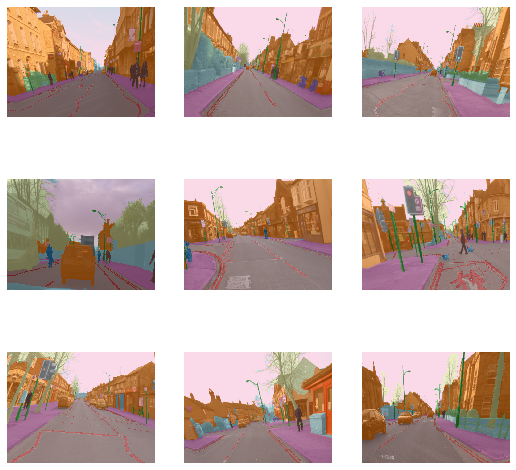

In [ ]:
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dbunch.vocab = codes

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    input = input.argmax(dim=1)
    target = target.squeeze(1)
    mask = target != void_code
    return (input[mask]==target[mask]).float().mean()

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01, eps=1e-8)

In [ ]:
learn = unet_learner(dbunch, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid)

In [ ]:
x,y = learn.dbunch.one_batch()
with torch.no_grad(): z = learn.model.eval()(x)

In [ ]:
input = z.argmax(dim=1)
target = y.squeeze(1)
type(input),type(target)

(torch.Tensor, local.transform.TensorMask)

In [ ]:
mask = target != void_code

In [ ]:
acc_camvid(z, y)

IndexError: too many indices for tensor of dimension 3

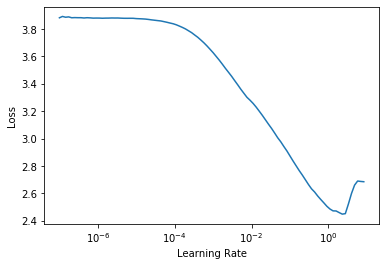

In [ ]:
learn.lr_find()

In [ ]:
lr= 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

KeyboardInterrupt: 

In [ ]:
learn.save('stage-1')

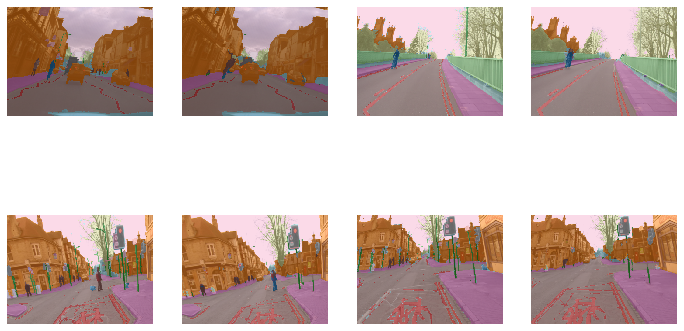

In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30)

In [ ]:
learn.load('stage-1')
learn.unfreeze()

In [ ]:
learn.opt.clear_state()

In [ ]:
lr = 1e-3
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.442170,0.421804,0.909241,00:37
1,0.443602,0.423117,0.907945,00:37
2,0.433395,0.408481,0.910808,00:37
3,0.431317,0.408127,0.910122,00:37
4,0.414105,0.397720,0.911726,00:38
5,0.400701,0.385548,0.912253,00:39
6,0.390416,0.376863,0.914716,00:38
7,0.374126,0.362562,0.916756,00:38
8,0.364691,0.357652,0.919018,00:38
9,0.361554,0.354400,0.920247,00:39


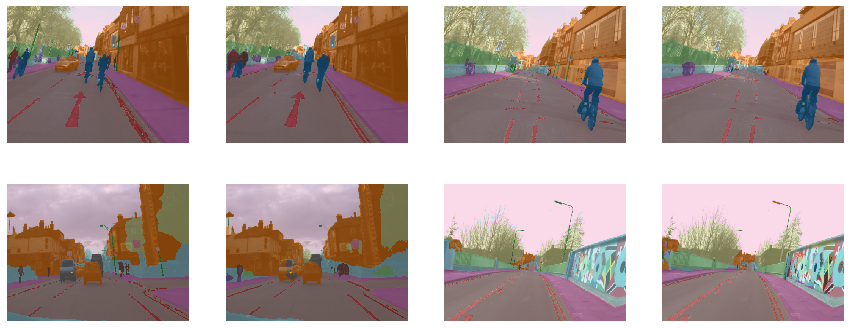

In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30, figsize=(15,6))